In [4]:
import numpy as np
import pylab as plt

import sklearn.datasets as datasets

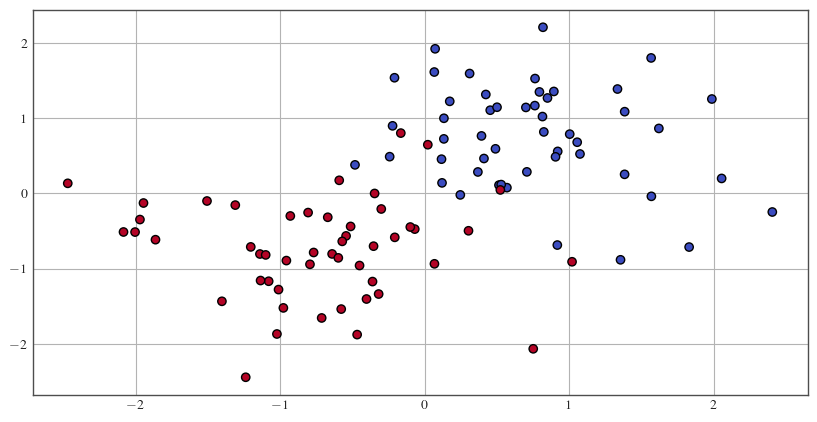

In [5]:
np.random.seed(1)

X, y = datasets.make_blobs([50, 50], cluster_std=4)
X = (X - X.mean(0)) / X.std(0)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

## Logistic Regression

In [6]:
from scipy.optimize import minimize
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class LogisticRegression:
    def __init__(self, num_dim=2, phi=None):
        self.num_dim = num_dim
        # self.weight = np.zeros(self.num_dim + 1)
        self.weight = np.random.randn(self.num_dim + 1)
        
        # just add bias if no basis functions are given
        if phi is None:
            self.phi = lambda x: np.hstack((np.ones(len(x)).reshape(-1, 1), x))
        else:
            self.phi = phi

    def predict(self, X):
        phi = self.phi(X)
        logits = phi @ self.weight
        return logits

    def predict_proba(self, X):
        logits = self.predict(X)
        return sigmoid(logits)

    def error(self, X, y):
        probas = self.predict_proba(X)
        probas = np.clip(probas, 1e-9, 1-1e-9)
        cross_entropy = - np.sum(y * np.log(probas) + (1 - y) * np.log(1 - probas))
        return cross_entropy

    def fit_sgd(self, X, y, num_iter=10, lr=1e-2):
        self.history = []

        phi = self.phi(X)
        shuffle_idx = np.random.permutation(len(X))
        for _ in range(num_iter):
            for n in shuffle_idx:
                proba = sigmoid(phi[n].reshape(1, -1) @ self.weight).item()
                grad_w = (proba - y[n]) * phi[n]
                self.weight = self.weight - lr*grad_w
            self.history.append({'error': self.error(X, y)})

    def fit_irls(self, X, y, max_iter=100, num_iter=10):
        self.history = []

        phi = self.phi(X)
        for _ in range(num_iter):
            probas = sigmoid(np.dot(phi, self.weight))
            R = np.diag(probas * (1-probas))

            hessian_w = phi.T @ R @ phi
            grad_w = phi.T @ (probas - y)

            self.weight = self.weight - np.dot(np.linalg.inv(hessian_w + np.eye(len(hessian_w))), grad_w)
            self.history.append({'error': self.error(X, y)})

    def fit_bfgs(self, X, y):
        def loss(weights): 
            probas = sigmoid(self.phi(X) @ weights)
            probas = np.clip(probas, 1e-9, 1-1e-9)
            return -np.sum(y * np.log(probas) + (1 - y) * np.log(1 - probas))
        self.history = []
        result = minimize(loss, self.weight, method='BFGS', callback=lambda w: self.history.append({'error': loss(w)}))
        self.weight = result.x

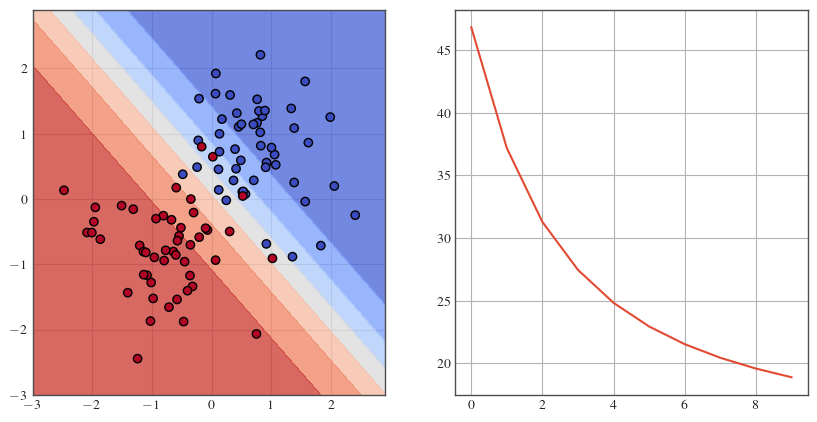

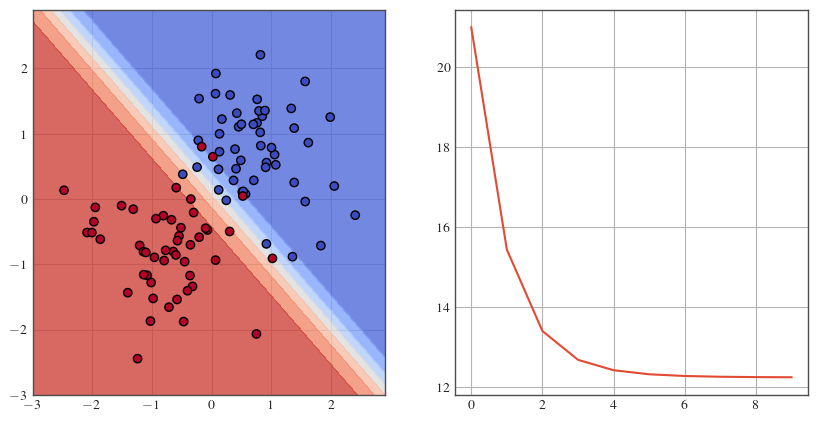

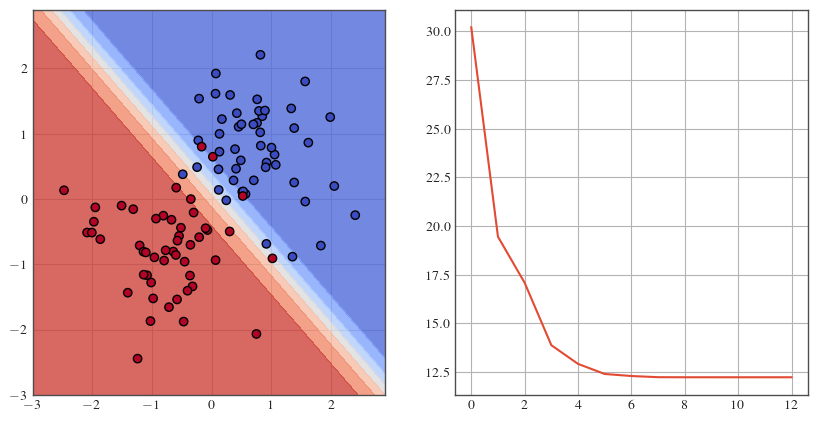

In [7]:
np.random.seed(1)
model = LogisticRegression()
model.fit_sgd(X, y)

plt.figure(figsize=(10,5))

xx, yy = np.mgrid[-3:3:.1, -3:3:.1]
zz = np.stack((xx.ravel(), yy.ravel()), axis=1)
probas = model.predict_proba(zz)

plt.subplot(121)
plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.subplot(122)
plt.plot([d['error'] for d in model.history])
plt.show()

np.random.seed(1)
model = LogisticRegression()
model.fit_irls(X, y)

plt.figure(figsize=(10,5))
xx, yy = np.mgrid[-3:3:.1, -3:3:.1]
zz = np.stack((xx.ravel(), yy.ravel()), axis=1)
probas = model.predict_proba(zz)

plt.subplot(121)
plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.subplot(122)
plt.plot([d['error'] for d in model.history])
plt.show()

np.random.seed(1)
model = LogisticRegression()
model.fit_bfgs(X, y)

plt.figure(figsize=(10,5))
xx, yy = np.mgrid[-3:3:.1, -3:3:.1]
zz = np.stack((xx.ravel(), yy.ravel()), axis=1)
probas = model.predict_proba(zz)

plt.subplot(121)
plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.subplot(122)
plt.plot([d['error'] for d in model.history])

plt.show()

## Bayesian Logistic Regression

In [8]:
class BayesianLogisticRegression(LogisticRegression):

    def predict_proba(self, X, mean_field=False, lmb=np.pi/8):
        if mean_field:
            phi = self.phi(X)
            logits = np.dot(phi, self.weight)
            var = phi @ self.posterior_cov @ phi.T
            logits_scaled = logits / (1 + lmb * np.diag(var))
            probas = sigmoid(logits_scaled)
        else:
            probas = super().predict_proba(X)
        return probas


    def fit_laplace(self, X, y, num_iter=10):

        # Get MAP solution
        # self.fit_irls(X, y, num_iter)
        self.fit_bfgs(X, y)

        # Compute cov with laplace approx
        phi = self.phi(X)
        prior_cov = np.eye(self.num_dim + 1)
        probas = self.predict_proba(X)
        R = np.diag(probas * (1 - probas ))

        self.posterior_precision = np.linalg.inv(prior_cov) + phi.T @ R @ phi
        self.posterior_cov = np.linalg.inv(self.posterior_precision)

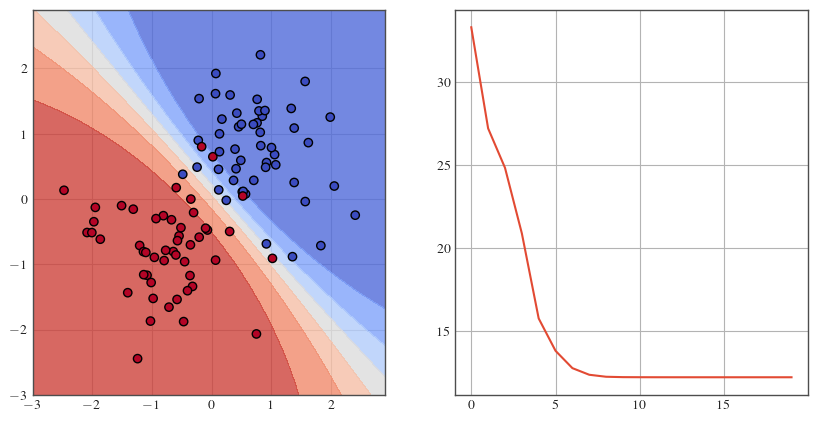

In [9]:
model = BayesianLogisticRegression()
model.fit_laplace(X, y)

plt.figure(figsize=(10,5))

xx, yy = np.mgrid[-3:3:.1, -3:3:.1]
zz = np.stack((xx.ravel(), yy.ravel()), axis=1)
probas = model.predict_proba(zz, mean_field=True)

plt.subplot(121)
plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.subplot(122)
plt.plot([d['error'] for d in model.history])

plt.show()

## Bayesian Updating
### Unsupervised

In [10]:
class BayesianLogisticRegression(BayesianLogisticRegression):
    def update(self, X_new, y_new=None):
        phi = self.phi(X_new)
        probas = self.predict_proba(X_new)
        R = np.diag(probas * (1 - probas))

        self.posterior_precision = self.posterior_precision + phi.T @ R @ phi
        self.posterior_cov = np.linalg.inv(self.posterior_precision)

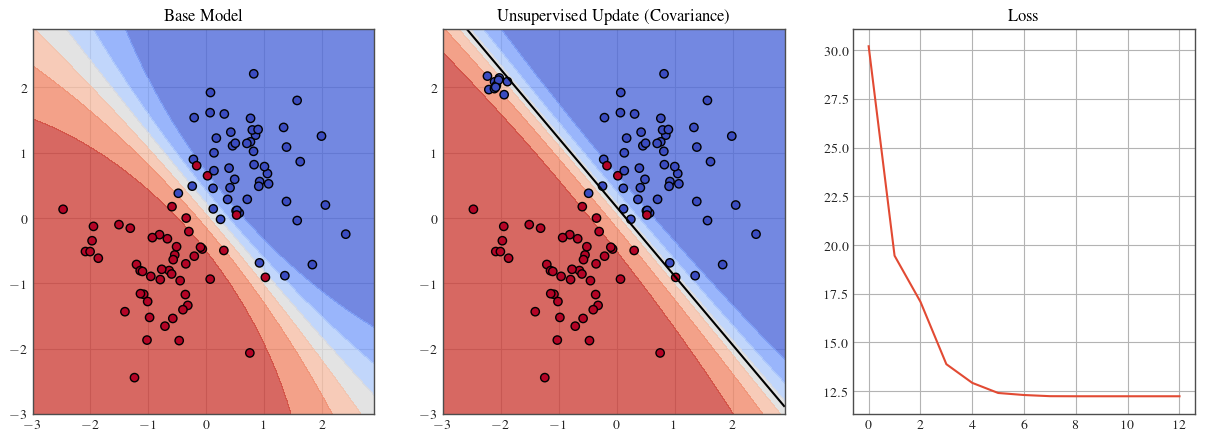

In [11]:
np.random.seed(1)
model = BayesianLogisticRegression()
model.fit_laplace(X, y)

plt.figure(figsize=(15,5))

xx, yy = np.mgrid[-3:3:.1, -3:3:.1]
zz = np.stack((xx.ravel(), yy.ravel()), axis=1)
probas = model.predict_proba(zz, mean_field=True)

plt.subplot(131)
plt.title('Base Model')
plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.subplot(132)
plt.title('Unsupervised Update (Covariance)')
X_new = np.random.multivariate_normal([-2, 2], cov=[[0.01, 0], [0, 0.01]], size=10)
y_new = np.zeros(len(X_new)).astype(int)
model.update(X_new)
probas = model.predict_proba(zz, mean_field=True)

plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[.5], colors='k')
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.subplot(133)
plt.title('Loss')
plt.plot([d['error'] for d in model.history])


plt.show()

### Supervised Stochastic Updating

In [12]:
class BayesianLogisticRegression(BayesianLogisticRegression):
    def update(self, X_new, y_new, lmb=1):
        phis = self.phi(X_new)
        targets = y_new

        mean = self.weight
        precision = self.posterior_precision
        cov = self.posterior_cov

        # Spiegelhalter update: see https://onlinelibrary.wiley.com/doi/epdf/10.1002/net.3230200507
        for i in range(lmb):
            for phi, target in zip(phis, targets):
                tmp1 = np.dot(cov, phi)
                tmp2 = np.outer(tmp1, tmp1)
                var = np.dot(phi, tmp1)
                proba = sigmoid(np.dot(mean, phi))
                num = proba * (1 - proba)
                denom = 1 + num * var
                cov_update = num / denom * tmp2
                cov_new = cov - cov_update

                # Update mean
                grad = (proba - target) * phi

                # print(np.linalg.norm(grad))
                mean -= np.dot(cov_new, grad)

                proba = sigmoid(np.dot(mean, phi))
                num = proba * (1 - proba)
                denom = 1 + num * var
                cov_update = num / denom * tmp2
                cov -= cov_update

        self.weight = mean
        self.posterior_cov = cov
        self.posterior_precision = np.linalg.inv(cov)

In [13]:
from ipywidgets import interact
@interact(mean0=(-3, 3, .1), mean1=(-3, 3, .1), size=(1, 20, 1))
def plot_update_retraining(mean0=-2, mean1=0, size=10):
    
    np.random.seed(1)

    mean_field_factor = np.pi/8
    model = BayesianLogisticRegression()
    model.fit_laplace(X, y)

    plt.figure(figsize=(15,5))

    xx, yy = np.mgrid[-3:3:.1, -3:3:.1]
    zz = np.stack((xx.ravel(), yy.ravel()), axis=1)
    probas = model.predict_proba(zz, mean_field=True, lmb=mean_field_factor)

    plt.subplot(131)
    plt.title('Base Model')
    plt.contour(xx, yy, probas.reshape(xx.shape), levels=[.5], colors='k')
    plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=10)

    plt.subplot(132)
    plt.title('Updated')
    X_new = np.concatenate([
        np.random.multivariate_normal([mean0, mean1], cov=[[0.01, 0], [0, 0.01]], size=size),
    ])
    y_new = np.concatenate([
        np.zeros(size).astype(int),
    ])
    model.update(X_new, y_new, lmb=1)
    probas = model.predict_proba(zz, mean_field=True, lmb=mean_field_factor)

    plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
    plt.contour(xx, yy, probas.reshape(xx.shape), levels=[.5], colors='k')
    plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new, s=50)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=10)

    plt.subplot(133)
    plt.title('Retrained')
    retrained_model = BayesianLogisticRegression()
    retrained_model.fit_laplace(np.vstack((X, X_new)), np.hstack((y, y_new)))
    probas = retrained_model.predict_proba(zz, mean_field=True, lmb=mean_field_factor)
    plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
    plt.contour(xx, yy, probas.reshape(xx.shape), levels=[.5], colors='k')
    plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new, s=50)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=10)

    plt.show()

interactive(children=(FloatSlider(value=-2.0, description='mean0', max=3.0, min=-3.0), FloatSlider(value=0.0, …

In [14]:
class BayesianLogisticRegression(BayesianLogisticRegression):
    def update(self, X_new, y_new, lmb=1):
        phis = self.phi(X_new)
        targets = y_new

        mean = self.weight
        precision = self.posterior_precision
        cov = self.posterior_cov

        # General update using update to precision matrix
        for phi, target in zip(phis, targets):
            # update precision
            proba = sigmoid(np.dot(mean, phi))
            new_precision = precision + proba * (1 - proba) * np.outer(phi, phi)
            new_cov = np.linalg.inv(new_precision)

            # Update mean
            grad = (proba - target) * phi
            mean -= np.dot(new_cov, grad)

            proba = sigmoid(np.dot(mean, phi))
            precision += proba * (1 - proba) * np.outer(phi, phi)

        self.weight = mean
        self.posterior_precision = precision
        self.posterior_cov = np.linalg.inv(precision)

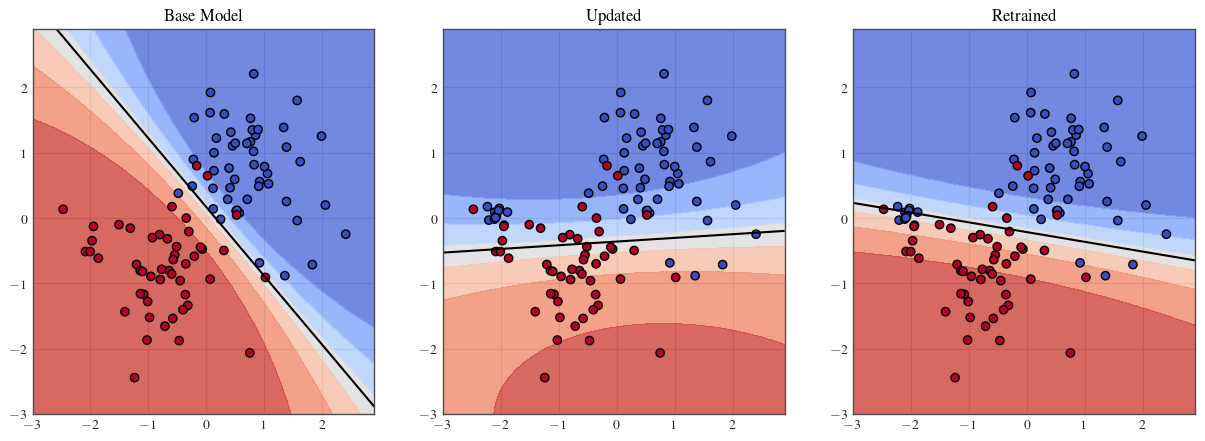

In [15]:
np.random.seed(1)

mean_field_factor = np.pi/8
model = BayesianLogisticRegression()
model.fit_laplace(X, y)

plt.figure(figsize=(15,5))

xx, yy = np.mgrid[-3:3:.1, -3:3:.1]
zz = np.stack((xx.ravel(), yy.ravel()), axis=1)
probas = model.predict_proba(zz, mean_field=True, lmb=mean_field_factor)

plt.subplot(131)
plt.title('Base Model')
plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[.5], colors='k')
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.subplot(132)
plt.title('Updated')
size=10
X_new = np.concatenate([
    np.random.multivariate_normal([-2, -0], cov=[[0.01, 0], [0, 0.01]], size=size),
    # np.random.multivariate_normal([0, -2], cov=[[0.01, 0], [0, 0.01]], size=10),
])
y_new = np.concatenate([
    np.zeros(size).astype(int),
])
model.update(X_new, y_new, lmb=1)
probas = model.predict_proba(zz, mean_field=True, lmb=mean_field_factor)

plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[.5], colors='k')
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.subplot(133)
plt.title('Retrained')
retrained_model = BayesianLogisticRegression()
retrained_model.fit_laplace(np.vstack((X, X_new)), np.hstack((y, y_new)))
probas = retrained_model.predict_proba(zz, mean_field=True, lmb=mean_field_factor)
plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[.5], colors='k')
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)
plt.scatter(X[:, 0], X[:, 1], c=y)


plt.show()

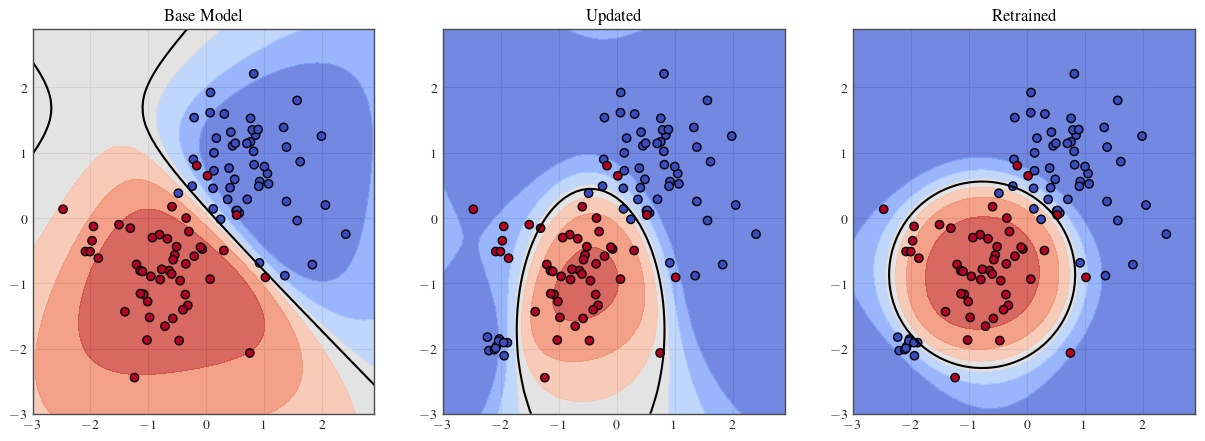

In [16]:
np.random.seed(1)
mean_field_factor = np.pi/8
model = BayesianLogisticRegression(phi=lambda x: np.hstack((np.ones(len(x)).reshape(-1, 1), x, x**2)), num_dim=4)
model.fit_laplace(X, y)
# 
plt.figure(figsize=(15,5))
# 
xx, yy = np.mgrid[-3:3:.1, -3:3:.1]
zz = np.stack((xx.ravel(), yy.ravel()), axis=1)
probas = model.predict_proba(zz, mean_field=True, lmb=mean_field_factor)
# 
plt.subplot(131)
plt.title('Base Model')
plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[.5], colors='k')
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.subplot(132)
plt.title('Updated')
X_new = np.random.multivariate_normal([-2, -2], cov=[[0.01, 0], [0, 0.01]], size=(10,))
y_new = np.zeros(len(X_new)).astype(int)
model.update(X_new, y_new, lmb=1)
probas = model.predict_proba(zz, mean_field=True, lmb=mean_field_factor)

plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[.5], colors='k')
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.subplot(133)
plt.title('Retrained')
retrained_model = BayesianLogisticRegression(phi=lambda x: np.hstack((np.ones(len(x)).reshape(-1, 1), x, x**2)), num_dim=4)
retrained_model.fit_laplace(np.vstack((X, X_new)), np.hstack((y, y_new)), num_iter=10)
probas = retrained_model.predict_proba(zz, mean_field=True, lmb=mean_field_factor)
plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[.5], colors='k')
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.show()

### Batch Updating

In [23]:
class BayesianLogisticRegression(BayesianLogisticRegression):
    def update(self, X_new, y_new, lmb=1):
        phis = self.phi(X_new)
        targets = y_new

        mean = self.weight
        precision = self.posterior_precision

        # TODO: momentum to avoid catastrophic forgetting..
        momentum = 1

        for i in range(lmb):
            probas = sigmoid(np.dot(phis, mean))
            R = np.diag(probas * (1 - probas))

            new_precision = precision + phis.T @ R @ phis
            new_cov = np.linalg.inv(new_precision)

            grad = np.dot(probas - targets, phis)

            # Update mean
            mean -= momentum * np.dot(new_cov, grad)

            probas = sigmoid(np.dot(phis, mean))
            R = np.diag(probas * (1 - probas))

            # update precision
            precision += momentum * (phis.T @ R @ phis)
            
        self.weight = mean
        self.posterior_precision = precision
        self.posterior_cov = np.linalg.inv(precision)

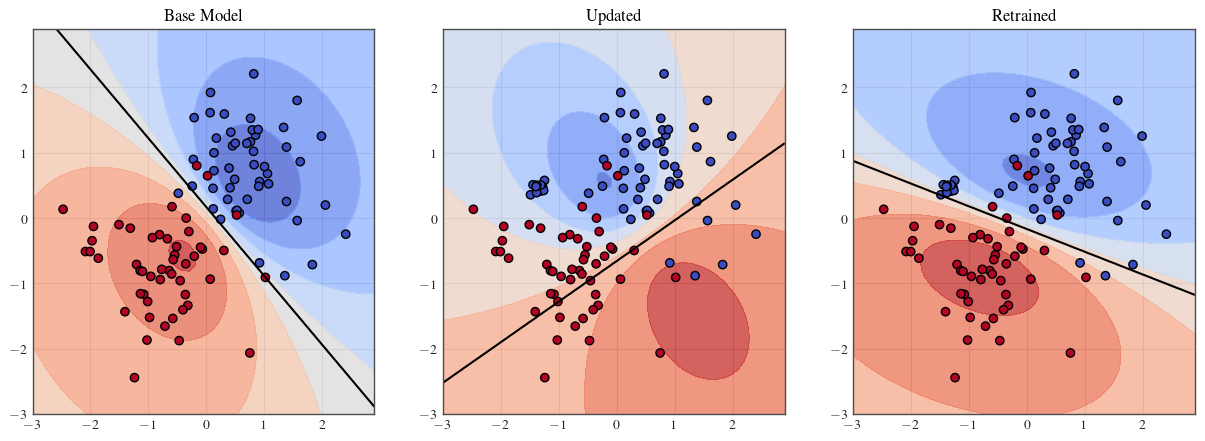

In [29]:
mean_field_factor = 5 # np.pi/8
model = BayesianLogisticRegression()
model.fit_laplace(X, y)

plt.figure(figsize=(15,5))

xx, yy = np.mgrid[-3:3:.1, -3:3:.1]
zz = np.stack((xx.ravel(), yy.ravel()), axis=1)
probas = model.predict_proba(zz, mean_field=True, lmb=mean_field_factor)

plt.subplot(131)
plt.title('Base Model')
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[.5], colors='k')
plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.subplot(132)
plt.title('Updated')
size=10
X_new = np.concatenate([
    np.random.multivariate_normal([-1.4, .5], cov=[[0.01, 0], [0, 0.01]], size=size),
    # np.random.multivariate_normal([0, -2], cov=[[0.01, 0], [0, 0.01]], size=10),
])
y_new = np.concatenate([
    np.zeros(size).astype(int),
])
model.update(X_new, y_new, lmb=1)
probas = model.predict_proba(zz, mean_field=True, lmb=mean_field_factor)

plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[.5], colors='k')
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.subplot(133)
plt.title('Retrained')
retrained_model = BayesianLogisticRegression()
retrained_model.fit_laplace(np.vstack((X, X_new)), np.hstack((y, y_new)))
probas = retrained_model.predict_proba(zz, mean_field=True, lmb=mean_field_factor)
plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[.5], colors='k')
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)
plt.scatter(X[:, 0], X[:, 1], c=y)


plt.show()

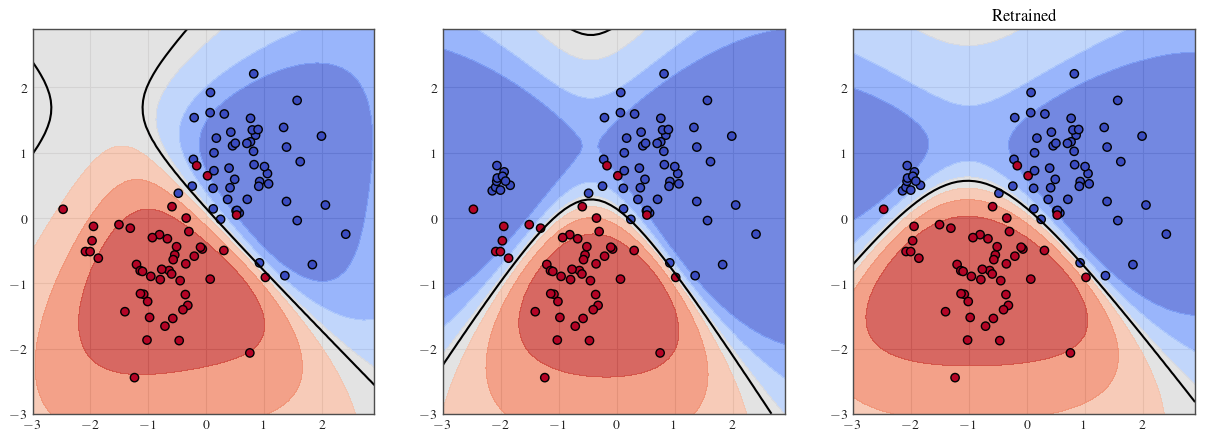

In [30]:
# np.random.seed(1)
mean_field_factor = np.pi/8
model = BayesianLogisticRegression(phi=lambda x: np.hstack((np.ones(len(x)).reshape(-1, 1), x, x**2)), num_dim=4)
model.fit_laplace(X, y)

plt.figure(figsize=(15,5))

xx, yy = np.mgrid[-3:3:.1, -3:3:.1]
zz = np.stack((xx.ravel(), yy.ravel()), axis=1)
probas = model.predict_proba(zz, mean_field=True, lmb=mean_field_factor)

plt.subplot(131)
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[.5], colors='k')
plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.subplot(132)
X_new = np.concatenate([    np.random.multivariate_normal([-2, .5], cov=[[0.01, 0], [0, 0.01]], size=10),
    # np.random.multivariate_normal([0, -2], cov=[[0.01, 0], [0, 0.01]], size=10),
])
y_new = np.concatenate([
    np.zeros(len(X_new)).astype(int),
])
model.update(X_new, y_new, lmb=100)
probas = model.predict_proba(zz, mean_field=True, lmb=mean_field_factor)

plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[.5], colors='k')
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.subplot(133)
plt.title('Retrained')
retrained_model = BayesianLogisticRegression(phi=lambda x: np.hstack((np.ones(len(x)).reshape(-1, 1), x, x**2)), num_dim=4)
retrained_model.fit_laplace(np.vstack((X, X_new)), np.hstack((y, y_new)))
probas = retrained_model.predict_proba(zz, mean_field=True, lmb=mean_field_factor)
plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=0.8)
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[.5], colors='k')
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.show()

## PAL

In [31]:
class BayesianLogisticRegression(BayesianLogisticRegression):
    def update(self, X_new, y_new, lmb=1):
        phis = self.phi(X_new)
        targets = y_new

        mean = self.weight
        precision = self.posterior_precision
        cov = self.posterior_cov

        # Spiegelhalter update: see https://onlinelibrary.wiley.com/doi/epdf/10.1002/net.3230200507
        for i in range(lmb):
            for phi, target in zip(phis, targets):
                tmp1 = np.dot(cov, phi)
                tmp2 = np.outer(tmp1, tmp1)
                var = np.dot(phi, tmp1)
                proba = sigmoid(np.dot(mean, phi))
                num = proba * (1 - proba)
                denom = 1 + num * var
                cov_update = num / denom * tmp2
                cov_new = cov - cov_update

                # Update mean
                grad = (proba - target) * phi

                # print(np.linalg.norm(grad))
                mean -= np.dot(cov_new, grad)

                proba = sigmoid(np.dot(mean, phi))
                num = proba * (1 - proba)
                denom = 1 + num * var
                cov_update = num / denom * tmp2
                cov -= cov_update

        self.weight = mean
        self.posterior_cov = cov
        self.posterior_precision = np.linalg.inv(cov)

In [32]:
from copy import deepcopy
class BayesianLogisticRegression(BayesianLogisticRegression):
    def gain(self, X_cand, X_eval, lmb, num_classes=2):
        mean_field_factor = 5# .001 # np.pi / 8 # 100

        phis_cand = self.phi(X_cand)
        probas_cand = self.predict_proba(X_cand, mean_field=True, lmb=mean_field_factor)
        y_pred_cand = (probas_cand > 0.5).astype(int)

        phis_eval = self.phi(X_eval)
        probas_eval = self.predict_proba(X_eval, mean_field=True, lmb=mean_field_factor)
        y_pred_eval = (probas_eval > 0.5).astype(int)

        gains = np.zeros(len(X_cand))
        for i_cand, phi_cand in enumerate(phis_cand):
            gain = 0
            for target in range(num_classes):

                # UPDATE
                # mean = deepcopy(self.weight)
                # cov = deepcopy(self.posterior_cov)
                # precision = deepcopy(self.posterior_precision)
                # for i in range(lmb):
                #     tmp1 = np.dot(cov, phi_cand)
                #     tmp2 = np.outer(tmp1, tmp1)
                #     var = np.dot(phi_cand, tmp1)
                #     proba = sigmoid(np.dot(mean, phi_cand))
                #     num = proba * (1 - proba)
                #     denom = 1 + num * var
                #     cov_update = num / denom * tmp2
                #     cov_new = cov - cov_update

                #     # Update mean
                #     grad = (proba - target) * phi_cand
                #     mean -= np.dot(cov_new, grad)

                #     proba = sigmoid(np.dot(mean, phi_cand))
                #     num = proba * (1 - proba)
                #     denom = 1 + num * var
                #     cov_update = num / denom * tmp2
                #     cov -= cov_update

                # logits = np.dot(phi_cand, self.weight)
                # var = phi_cand @ cov @ phi_cand.T
                # logits_scaled = logits / (1 + mean_field_factor * np.diag(var))
                # probas_eval_new = sigmoid(logits_scaled)

                # if not np.all(old_mean == mean):
                # if i_cand == 1000:
                #     print(X_cand[i_cand])
                #     print('retraining changed sth. Old mean is: {} and new mean is: {}'.format(old_mean, self.weight))
                #     print(np.all(old_mean == mean))
                #     print(np.all(np.isclose(old_mean, mean)))
                #     return sigmoid(np.dot(phis_cand, old_mean) / (1 + lmb * np.diag(phis_cand @ old_cov @ phis_cand.T)))

                # Train model
                old_mean = deepcopy(self.weight)
                old_cov = deepcopy(self.posterior_cov)
                old_prec = deepcopy(self.posterior_precision)
                num = 10
                X_new = np.vstack((X, [X_cand[i_cand]]*num))
                y_new = np.hstack((y, [target]*num))
                self.weight = np.zeros(self.num_dim+1)
                self.fit_laplace(X_new, y_new)
                probas_eval_new = self.predict_proba(X_eval, mean_field=True, lmb=mean_field_factor)
                y_pred_eval_new = (probas_eval_new > 0.5).astype(int)
                self.weight = old_mean
                self.cov = old_cov
                self.posterior_precision = old_prec

                # Compute gain
                acc_gain_0 = (1-probas_eval_new)*(y_pred_eval_new == 0).astype(int) - (1-probas_eval_new)*(y_pred_eval == 0).astype(int)
                acc_gain_1 = probas_eval_new*(y_pred_eval_new == 1).astype(int) - probas_eval_new*(y_pred_eval == 1).astype(int)
                gain += probas_cand[i_cand]**target*(1-probas_cand[i_cand])**(1-target)*np.sum(acc_gain_0 + acc_gain_1)

            gains[i_cand] = gain
        return gains

In [33]:
np.random.seed(1)

mean_field_factor = np.pi/8
model = BayesianLogisticRegression()
# model = BayesianLogisticRegression(phi=lambda x: np.hstack((np.ones(len(x)).reshape(-1, 1), x, x**2)), num_dim=4)
model.fit_laplace(X, y)
# model.gain(X_new, X, lmb=1000, num_classes=2)

X_new = np.concatenate([    
    np.random.multivariate_normal([-2, 1], cov=[[0.1, 0], [0, 0.1]], size=50),
])
y_new = np.concatenate([
    np.zeros(len(X_new)).astype(int),
])
xx, yy = np.mgrid[-3:3:.1, -3:3:.1]
zz = np.stack((xx.ravel(), yy.ravel()), axis=1)
gains = model.gain(zz, np.vstack((X, )), lmb=10, num_classes=2)

KeyboardInterrupt: 

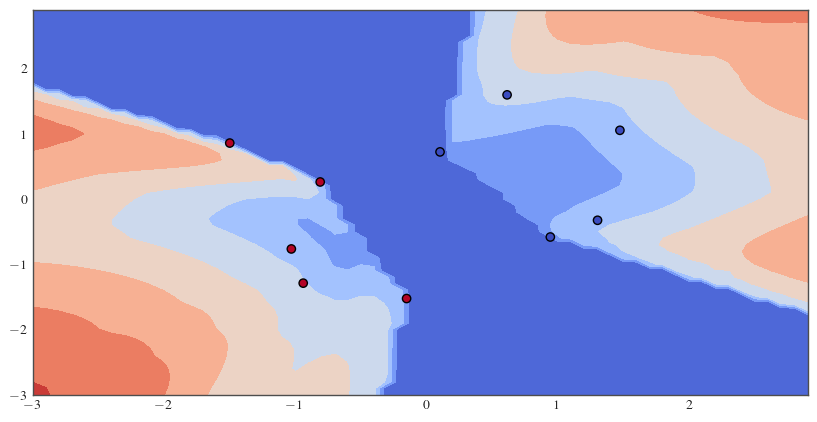

In [30]:
plt.contourf(xx, yy, gains.reshape(xx.shape))
# plt.contour(xx, yy, gains.reshape(xx.shape), levels=[.5], colors='k')
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

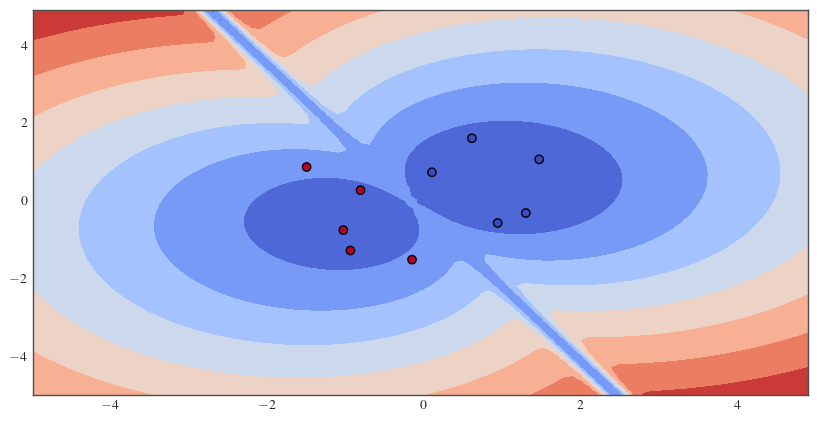

In [23]:
from copy import deepcopy

class BayesianLogisticRegression(BayesianLogisticRegression):
    def gain(self, X_cand, X_eval, lmb, num_classes=2):
        mean_field_factor = 5 # 100 # np.pi / 8 # 100

        phis_cand = self.phi(X_cand)
        probas_cand = self.predict_proba(X_cand, mean_field=True, lmb=mean_field_factor)
        y_pred_cand = (probas_cand > 0.5).astype(int)

        phis_eval = self.phi(X_eval)
        probas_eval = self.predict_proba(X_eval, mean_field=True, lmb=mean_field_factor)
        y_pred_eval = (probas_eval > 0.5).astype(int)

        gains = np.zeros(len(X_cand))
        for i_cand, phi_cand in enumerate(phis_cand):
            gain = 0
            for target in range(num_classes):

                # UPDATE
                mean = deepcopy(self.weight)
                cov = deepcopy(self.posterior_cov)
                precision = deepcopy(self.posterior_precision)
                for i in range(lmb):
                    tmp1 = np.dot(cov, phi_cand)
                    tmp2 = np.outer(tmp1, tmp1)
                    var = np.dot(phi_cand, tmp1)
                    proba = sigmoid(np.dot(mean, phi_cand))
                    num = proba * (1 - proba)
                    denom = 1 + num * var
                    cov_update = num / denom * tmp2
                    cov_new = cov - cov_update

                    # Update mean
                    grad = (proba - target) * phi_cand
                    # mean -= np.dot(cov_new, grad)

                    # proba = sigmoid(np.dot(mean, phi_cand))
                    # num = proba * (1 - proba)
                    # denom = 1 + num * var
                    # cov_update = num / denom * tmp2
                    # cov -= cov_update

                    gain += probas_cand[i_cand]**target*(1-probas_cand[i_cand])**(1-target)*np.linalg.norm(np.dot(cov_new, grad))
                    # gain += probas_cand[i_cand]**target*(1-probas_cand[i_cand])**(1-target)*np.linalg.norm(grad)

            gains[i_cand] = gain
        return gains

np.random.seed(1)
model = BayesianLogisticRegression()
# model = BayesianLogisticRegression(phi=lambda x: np.hstack((np.ones(len(x)).reshape(-1, 1), x, x**2)), num_dim=4)
model.fit_laplace(X, y)
domain = 5
res = .1
xx, yy = np.mgrid[-domain:domain:res, -domain:domain:res]
zz = np.stack((xx.ravel(), yy.ravel()), axis=1)
gains = model.gain(zz, np.vstack((X, )), lmb=1, num_classes=2)
plt.contourf(xx, yy, gains.reshape(xx.shape))
# plt.contour(xx, yy, gains.reshape(xx.shape), levels=[.5], colors='k')
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()